## Channel Attribution Modelling - Digital Marketing

### Data Load and Preprocessing

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import tee

In [2]:
#Importing the data
df = pd.read_csv('/Users/sanchalisinghal/Desktop/ML Models/Marketing Projects/Channel Attribution Model/attribution data.csv')
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [3]:
# Convert 'time' column to datetime and sort the data
df['time'] = pd.to_datetime(df['time'])
df_sorted = df.sort_values(by=['cookie', 'time']).reset_index(drop=True)

# Basic cleaning: lowercasing channel names and interaction types
df_sorted['channel'] = df_sorted['channel'].str.strip().str.lower()
df_sorted['interaction'] = df_sorted['interaction'].str.strip().str.lower()

# Check for missing values
missing_values = df_sorted.isnull().sum()

# Summarize number of unique users and interactions
unique_users = df_sorted['cookie'].nunique()
interaction_types = df_sorted['interaction'].value_counts()

df_sorted.head(), missing_values, unique_users, interaction_types

(                      cookie                      time interaction  \
 0  00000FkCnDfDDf0iC97iC703B 2018-07-03 13:02:11+00:00  impression   
 1  00000FkCnDfDDf0iC97iC703B 2018-07-17 19:15:07+00:00  impression   
 2  00000FkCnDfDDf0iC97iC703B 2018-07-24 15:51:46+00:00  impression   
 3  00000FkCnDfDDf0iC97iC703B 2018-07-29 07:44:51+00:00  impression   
 4  0000nACkD9nFkBBDECD3ki00E 2018-07-03 09:44:57+00:00  impression   
 
    conversion  conversion_value         channel  
 0           0               0.0       instagram  
 1           0               0.0  online display  
 2           0               0.0  online display  
 3           0               0.0  online display  
 4           0               0.0     paid search  ,
 cookie              0
 time                0
 interaction         0
 conversion          0
 conversion_value    0
 channel             0
 dtype: int64,
 240108,
 interaction
 impression    569098
 conversion     17639
 Name: count, dtype: int64)

#### Building User Journeys for Converted Users

In [8]:
# Add cumulative conversion flag per user
df['conversion_cumsum'] = df.groupby('cookie')['conversion'].cumsum()

# Keep only events before or at the first conversion
df = df[df['conversion_cumsum'] <= 1].copy()

In [10]:
# Aggregate user journeys using groupby
journey_df = (
    df.groupby('cookie')
      .agg({
          'channel': list,
          'conversion': 'max',
          'conversion_value': lambda x: x[df.loc[x.index, 'conversion'] == 1].max() if any(df.loc[x.index, 'conversion'] == 1) else 0
      })
      .rename(columns={'channel': 'journey'})
      .reset_index()
)

### Single Touch Attribution
These models assign 100% of credit to a single marketing channel either the first or the last. This is a naive approach and should only be used if there are <5 user totuch points. Between First and Last click, the latter is more widely used.

#### First Click Models
The rationale behind this model is that this is the first time a user is being made aware of the product (top of the funnel).

In [12]:
def first_click_attribution(df):
    contrib = defaultdict(float)

    # Filter only converted journeys
    converted = df[df['conversion'] == 1]

    # Accumulate contribution for first-click
    for _, row in converted.iterrows():
        if row['journey']:
            contrib[row['journey'][0]] += row['conversion_value']

    # Calculate total conversion value from first touches
    total_value = sum(contrib.values())

    # Convert to percentage format
    contrib_percentage = {ch: round((val / total_value) * 100, 2) for ch, val in contrib.items()} if total_value > 0 else {}
    
    return contrib_percentage

#### Last Click Attribution

In [15]:
def last_click_attribution(df):
    contrib = defaultdict(float)

    # Only include converted journeys
    converted = df[df['conversion'] == 1]

    for _, row in converted.iterrows():
        if row['journey']:
            contrib[row['journey'][-1]] += row['conversion_value']

    total_value = sum(contrib.values())
    contrib_percentage = {ch: round((val / total_value) * 100, 2) for ch, val in contrib.items()} if total_value > 0 else {}
    
    return contrib_percentage

In [17]:
first_click_pct = first_click_attribution(journey_df)
last_click_pct = last_click_attribution(journey_df)

print("First Click Weights%:", first_click_pct)
print("Last Click Weights%:", last_click_pct)

First Click Weights%: {'Paid Search': 26.97, 'Facebook': 29.29, 'Online Video': 18.35, 'Instagram': 13.23, 'Online Display': 12.17}
Last Click Weights%: {'Paid Search': 25.7, 'Facebook': 30.07, 'Online Video': 19.43, 'Instagram': 12.74, 'Online Display': 12.06}


In [19]:
# Collect all unique channels
all_channels_st = set(first_click_pct) | set(last_click_pct)

{'Facebook', 'Instagram', 'Online Display', 'Online Video', 'Paid Search'}

In [49]:
# Build the DataFrame dynamically
attribution_df_st = pd.DataFrame({
    'Channel': list(all_channels_st),
    'First Click': [first_click_pct.get(ch, 0) for ch in all_channels_st],
    'Last Click': [last_click_pct.get(ch, 0) for ch in all_channels_st]
}).set_index('Channel')

In [56]:
# Sort for consistent display
attribution_df_st = attribution_df_st.sort_index()
attribution_df_st

,First Click,Last Click
Channel,,
Facebook,29.29,30.07
Instagram,13.23,12.74
Online Display,12.17,12.06
Online Video,18.35,19.43
Paid Search,26.97,25.70


Facebook and Paid Search dominate both ends and capturing + converting traffic. Worth investment across the funnel.
Online Video is more effective later possibly due to retargeting or product demos.
Instagram and Online Display might need optimization or be better suited for awareness campaigns.

### Multit-touch Attribution Models
For these models, credit is distributed to all the touchpoints in a user's jouney and provide a granular view than single touch models. When number of channels are in the range of 5-10, these models should be used. Mostly widely used models are Position Based: U-Shaped model.

#### Linear Attribution Model
The Linear Attribution Model gives each touchpoint the same amount of credit toward driving a conversion; it values every touchpoint evenly. 

In [64]:
def linear_attribution(df):
    contrib = defaultdict(float)

    # Only include converted journeys
    converted = df[df['conversion'] == 1]

    for _, row in converted.iterrows():
        journey = row['journey']
        if journey:
            split_value = row['conversion_value'] / len(journey)
            for channel in journey:
                contrib[channel] += split_value

    total_value = sum(contrib.values())
    contrib_percentage = {ch: round((val / total_value) * 100, 2) for ch, val in contrib.items()} if total_value > 0 else {}

    return contrib_percentage

#### U-Shaped Attribution 
40% first, 40% last, 20% distributed across middle

In [67]:
def u_shaped_attribution(df):
    contrib = defaultdict(float)

    converted = df[df['conversion'] == 1]

    for _, row in converted.iterrows():
        journey = row['journey']
        if not journey:
            continue
        
        conv_value = row['conversion_value']
        n = len(journey)
        
        if n == 1:
            contrib[journey[0]] += conv_value
        elif n == 2:
            contrib[journey[0]] += conv_value * 0.5
            contrib[journey[1]] += conv_value * 0.5
        else:
            contrib[journey[0]] += conv_value * 0.4
            contrib[journey[-1]] += conv_value * 0.4
            middle_value = (conv_value * 0.2) / (n - 2)
            for ch in journey[1:-1]:
                contrib[ch] += middle_value

    total_value = sum(contrib.values())
    return {ch: round((val / total_value) * 100, 2) for ch, val in contrib.items()} if total_value > 0 else {}

#### Position-Based Decay Attribution 
Weighted from start to end using decay curve

In [70]:
def position_decay_attribution(df, decay_factor=0.8):
    """
    Applies an exponential decay model:
    Weight = decay_factor^position (normalized)
    """
    contrib = defaultdict(float)
    converted = df[df['conversion'] == 1]

    for _, row in converted.iterrows():
        journey = row['journey']
        if not journey:
            continue
        
        conv_value = row['conversion_value']
        n = len(journey)
        
        # Assign weights with decay
        weights = [decay_factor ** i for i in range(n)]
        total_weight = sum(weights)
        normalized_weights = [w / total_weight for w in weights]
        
        for ch, w in zip(journey, normalized_weights):
            contrib[ch] += conv_value * w

    total_value = sum(contrib.values())
    return {ch: round((val / total_value) * 100, 2) for ch, val in contrib.items()} if total_value > 0 else {}

In [72]:
linear_pct = linear_attribution(journey_df)
u_shaped_pct = u_shaped_attribution(journey_df)
decay_pct = position_decay_attribution(journey_df, decay_factor=0.8)

print("Linear %:", linear_pct)
print("U-Shaped %:", u_shaped_pct)
print("Position Decay %:", decay_pct)

Linear %: {'Paid Search': 26.48, 'Facebook': 29.59, 'Online Video': 19.09, 'Instagram': 12.86, 'Online Display': 11.98}
U-Shaped %: {'Paid Search': 26.4, 'Facebook': 29.62, 'Online Video': 18.95, 'Instagram': 12.95, 'Online Display': 12.08}
Position Decay %: {'Paid Search': 26.66, 'Facebook': 29.5, 'Online Video': 18.95, 'Instagram': 12.89, 'Online Display': 12.01}


In [74]:
# Combine into a DataFrame
all_channels_mt = set().union(linear_pct, u_shaped_pct, decay_pct)
all_channels_mt

{'Facebook', 'Instagram', 'Online Display', 'Online Video', 'Paid Search'}

In [80]:
attribution_df_mt = pd.DataFrame({
    'Channel': list(all_channels_mt),
    'Linear': [linear_pct.get(ch, 0) for ch in all_channels_mt],
    'U-Shaped': [u_shaped_pct.get(ch, 0) for ch in all_channels_mt],
    'Position Decay': [decay_pct.get(ch, 0) for ch in all_channels_mt]
}).set_index('Channel')

In [82]:
# Sort for consistent display
attribution_df_mt = attribution_df_mt.sort_index()
attribution_df_mt

,Linear,U-Shaped,Position Decay
Channel,,,
Facebook,29.59,29.62,29.50
Instagram,12.86,12.95,12.89
Online Display,11.98,12.08,12.01
Online Video,19.09,18.95,18.95
Paid Search,26.48,26.40,26.66


Facebook consistently dominates attribution across all models. Paid Search excels at initiating journeys, while Online Video gains influence later in the funnel. Instagram and Online Display play supportive roles with room for optimization.

### Probabilistic Attribution Models
Models that are based on stastical analysis and machine learning techniques to derive probability of conversion across all marketing channel touchpoints. 

### Markov Attribution Model

The Markov Attribution model will represent user journeys as a directed graph, with the nodes being the touchpoints or "states", and the graph's connecting edges being the observed transitions between those states.

The key ingredient to the model is the transition probabilities (likelihood of moving between states). The number of times users have transitioned between two states is converted into a probability, and the complete graph can be used to measure the importance of each state and most likely paths to success.

This model should be used when the number of channels for a particular campaign is between 10 and 15.

1. full paths with Start and Conversion/Null
2. transition matrix (channel → channel probabilities)
3. Markov chains for exact conversion rate estimation
4. removal effects deterministically (no randomness)
5. no negative values
6. percentage-based attribution

In [92]:
def markov_chain_attribution(journey_df, user_col='cookie', path_col='journey', conv_col='conversion', value_col='conversion_value'):
    # Step 1: Generate full paths with start and end states
    journey_df['path'] = journey_df.apply(
        lambda row: ['Start'] + row[path_col] + (['Conversion'] if row[conv_col] == 1 else ['Null']),
        axis=1
    )

    # Step 2: Count transitions
    transition_counts = defaultdict(int)
    for path in journey_df['path']:
        for i in range(len(path) - 1):
            transition_counts[(path[i], path[i + 1])] += 1

    # Step 3: Create transition matrix
    states = sorted(set(s for pair in transition_counts for s in pair))
    matrix = pd.DataFrame(0.0, index=states, columns=states)

    for (src, dst), count in transition_counts.items():
        matrix.at[src, dst] += count

    matrix = matrix.div(matrix.sum(axis=1), axis=0).fillna(0)

    # Step 4: Identify absorbing and transient states
    absorbing = ['Conversion', 'Null']
    transient = [s for s in matrix.index if s not in absorbing]

    Q = matrix.loc[transient, transient]
    R = matrix.loc[transient, absorbing]

    # Step 5: Compute baseline conversion probability from Start
    I = np.eye(len(Q))
    N = np.linalg.inv(I - Q.values)
    B = np.dot(N, R.values)
    conv_probs = pd.DataFrame(B, index=Q.index, columns=R.columns)
    baseline_cr = conv_probs.loc['Start', 'Conversion']

    # Step 6: Compute removal effects for each channel
    removal_effects = {}
    for channel in Q.index:
        if channel == 'Start':
            continue

        # Remove channel from matrix
        Q_removed = Q.drop(index=channel, columns=channel)
        R_removed = R.drop(index=channel)

        I_removed = np.eye(len(Q_removed))
        try:
            N_removed = np.linalg.inv(I_removed - Q_removed.values)
            B_removed = np.dot(N_removed, R_removed.values)
            conv_probs_removed = pd.DataFrame(B_removed, index=Q_removed.index, columns=R.columns)
            cr_without = conv_probs_removed.loc['Start', 'Conversion'] if 'Start' in conv_probs_removed.index else 0
        except np.linalg.LinAlgError:
            cr_without = 0

        effect = max(0, baseline_cr - cr_without)
        removal_effects[channel] = effect

    # Step 7: Normalize to percentage-based attribution
    total = sum(removal_effects.values())
    attribution = {ch: round((val / total) * 100, 2) for ch, val in removal_effects.items()} if total > 0 else {}

    return pd.DataFrame.from_dict(attribution, orient='index', columns=['Weight (%)']).sort_values(by='Weight (%)', ascending=False)


In [94]:
markov_df = markov_chain_attribution(journey_df)
print(markov_df)

                Weight (%)
Facebook             29.78
Paid Search          24.56
Instagram            17.14
Online Video         16.51
Online Display       12.01


Markov model reveals more nuanced contributions especially highlighting Instagram’s indirect influence.
It's more balanced than single-touch models and more data-driven than weighted multi-touch.
Great for allocating budget based on true incremental value.

Example user journey:

Start → Facebook → Instagram → Paid Search → Conversion
1. Last-click: Paid Search gets 100%
2. First-click: Facebook gets 100%
3. Linear: 25% each
4. U shaped: Facebook 40%, Instagram 20%, Paid Search 40%
5. Position Decay: Facebook 15%, Instagram 30%, Paid Search 55%
6. Markov: Tests what happens if Instagram is removed. If without Instagram, users don’t continue to Paid Search, conversion rate drops
→ Instagram gets credit for enabling the conversion

### Shapely Attribution Model

Based on cooperative game theory
It measures each channel's marginal contribution across all possible permutations of touchpoint combinations
Fair, data-driven, and accounts for order and synergy

In [99]:
from itertools import combinations, permutations
from collections import defaultdict
import pandas as pd

def powerset(channels):
    """All non-empty subsets of the journey"""
    return [set(comb) for r in range(1, len(channels)+1) for comb in combinations(channels, r)]

def shapley_attribution(journey_df, path_col='journey', conv_col='conversion', value_col='conversion_value'):
    shapley_values = defaultdict(float)

    # Only converted journeys
    converted = journey_df[journey_df[conv_col] == 1]

    for _, row in converted.iterrows():
        path = list(dict.fromkeys(row[path_col]))  # remove duplicates, keep order
        conv_value = row[value_col]
        n = len(path)
        
        if n == 0:
            continue
        
        for ch in path:
            contrib = 0
            for r in range(n):
                for subset in combinations([c for c in path if c != ch], r):
                    subset = set(subset)
                    with_ch = subset | {ch}
                    
                    # Value with ch - value without ch (here we use set length as a proxy)
                    marginal = 1 / len(with_ch) - (1 / len(subset) if subset else 0)
                    
                    # Weight by permutation likelihood
                    weight = (1 / comb(n, len(subset))) / n
                    contrib += weight * marginal

            shapley_values[ch] += conv_value * contrib

    # Normalize to percentages
    total = sum(shapley_values.values())
    shapley_pct = {k: round((v / total) * 100, 2) for k, v in shapley_values.items()}
    return pd.DataFrame.from_dict(shapley_pct, orient='index', columns=['Weight (%)']).sort_values(by='Weight (%)', ascending=False)

def comb(n, r):
    from math import comb as math_comb
    return math_comb(n, r)


In [101]:
shapley_df = shapley_attribution(journey_df)
print(shapley_df)


                Weight (%)
Paid Search          27.66
Facebook             27.46
Online Video         19.01
Instagram            13.61
Online Display       12.26


In [134]:
# Combine into a single DataFrame
all_channels_prob = set().union(markov_df.index, shapley_df.index)
all_channels_prob

{'Facebook', 'Instagram', 'Online Display', 'Online Video', 'Paid Search'}

In [138]:
attribution_df_pb = pd.DataFrame({
    'Channel': list(all_channels_prob),
    'Markov': [markov_df.loc[ch, 'Weight (%)'] if ch in shapley_df.index else 0 for ch in all_channels_prob],
    'Shapley': [shapley_df.loc[ch, 'Weight (%)'] if ch in shapley_df.index else 0 for ch in all_channels_prob]
}).set_index('Channel').sort_index()

In [140]:
attribution_df_pb

,Markov,Shapley
Channel,,
Facebook,29.78,27.46
Instagram,17.14,13.61
Online Display,12.01,12.26
Online Video,16.51,19.01
Paid Search,24.56,27.66


### Evaluate Results 
Find the Best Model across all Channels 

<Figure size 1400x600 with 0 Axes>

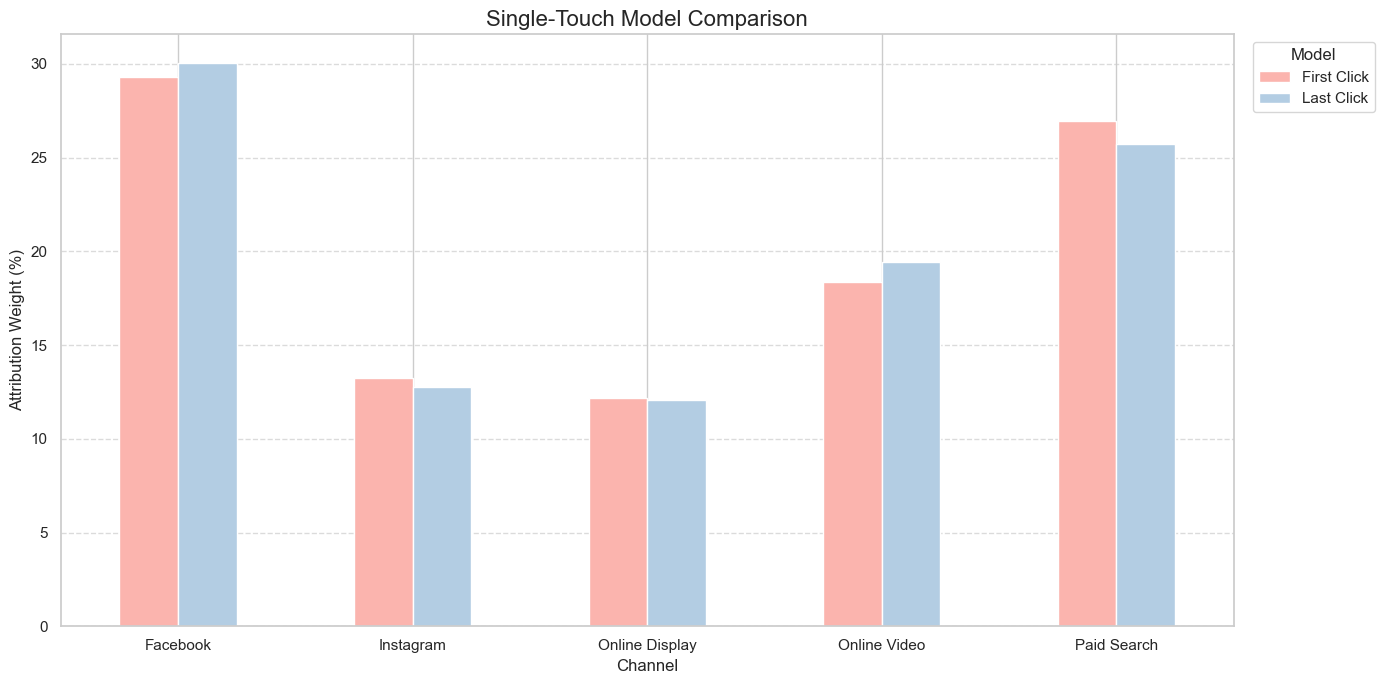

<Figure size 1400x600 with 0 Axes>

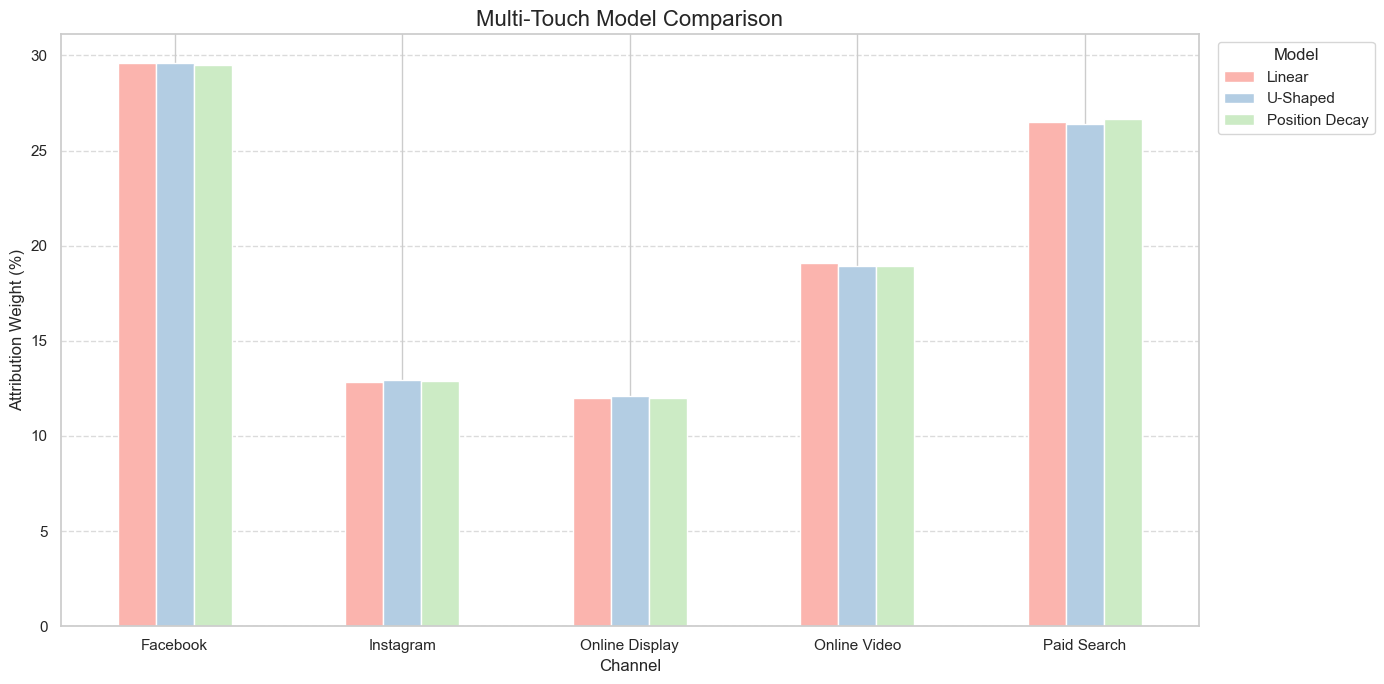

<Figure size 1400x600 with 0 Axes>

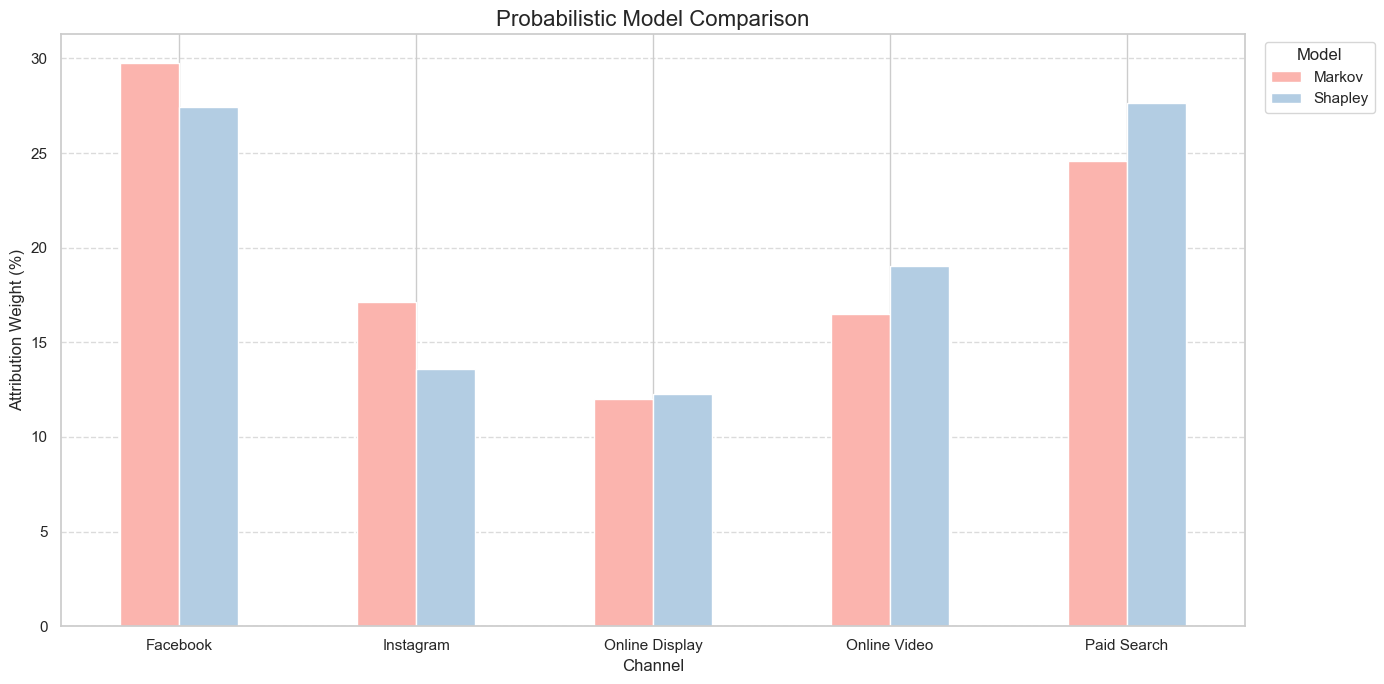

In [142]:
# Plot single touch
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
colors = sns.color_palette('Pastel1', n_colors=2)

ax = attribution_df_st.plot(kind='bar', figsize=(14, 7), color=colors)
plt.title("Single-Touch Model Comparison", fontsize=16)
plt.ylabel("Attribution Weight (%)")
plt.xlabel("Channel")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Model", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot multi touch
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
colors = sns.color_palette('Pastel1', n_colors=3)

ax = attribution_df_mt.plot(kind='bar', figsize=(14, 7), color=colors)
plt.title("Multi-Touch Model Comparison", fontsize=16)
plt.ylabel("Attribution Weight (%)")
plt.xlabel("Channel")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Model", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot prob models
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
colors = sns.color_palette('Pastel1', n_colors=2)

ax = attribution_df_pb.plot(kind='bar', figsize=(14, 7), color=colors)
plt.title("Probabilistic Model Comparison", fontsize=16)
plt.ylabel("Attribution Weight (%)")
plt.xlabel("Channel")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Model", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

Facebook and Paid Search consistently dominate across attribution models, while Online Display receives the least credit. This aggregated approach supports a more balanced investment decision, with future refinements possible through A/B testing.